In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

W0815 00:19:07.421837 140734880404928 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0815 00:19:10.354409 140734880404928 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset tf_flowers downloaded and prepared to /Users/dustin/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [13]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [14]:
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [15]:
# Split dataset
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set_raw = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set_raw = tfds.load("tf_flowers", split=train_split, as_supervised=True)

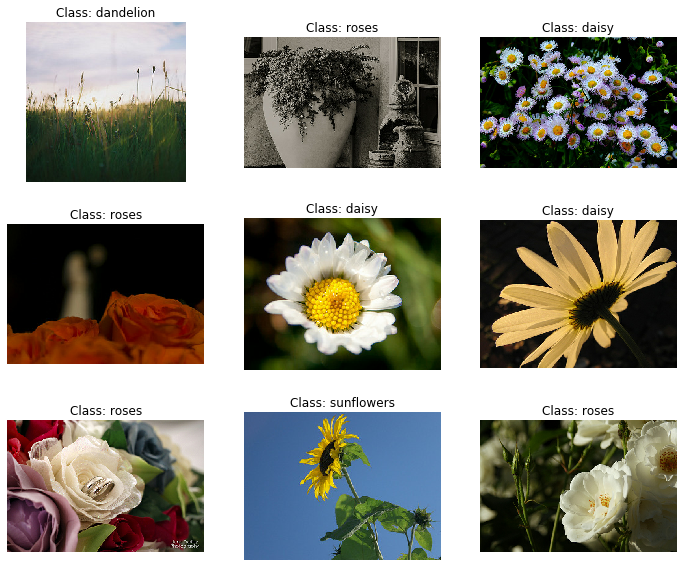

In [20]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [22]:
# preprocess image, expected size 224x224
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [24]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

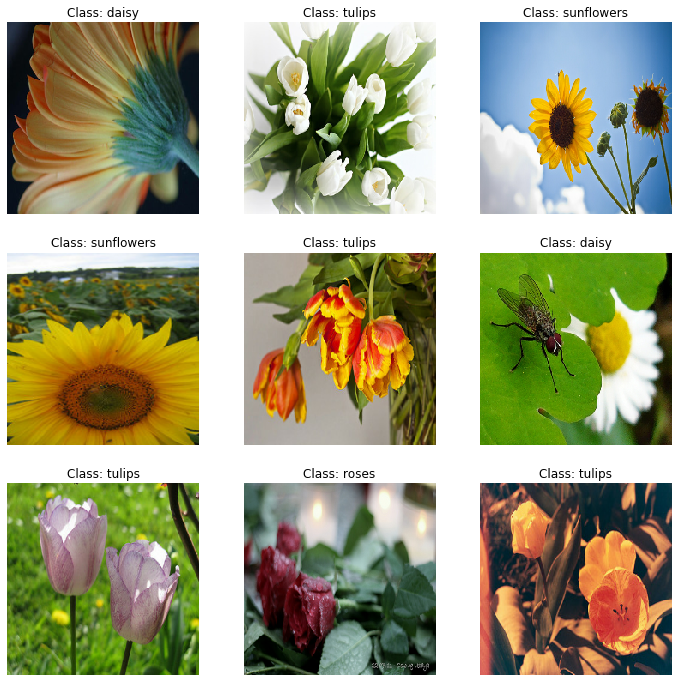

In [25]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [26]:
# Xception model pretrained on imagenet with the top layers removed
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# Global average pooling on the result of the base model
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# Fully connected layer connected to the pooling layer
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# New model with transfer learning
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 12s 0us/step


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)